In [6]:
import warnings
warnings.filterwarnings('ignore')

import glob
import cv2
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from copy import deepcopy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils


sns.set()

In [114]:
class LetersCNN:
    def __init__(self):
        self.X = []
        self.Y = []
        self.Train = []
        self.Test = []

    def load_data(self, path):
        data = pd.read_csv(path).astype('int32')
        new_col = ['label']
        for i in range(0, len(data.columns) - 1):
            new_col.append(i)
        data.columns = new_col
        self.data = data
    
    def split(self): #Split 75-25
        X = self.data.drop('label', axis=1)
        Y = self.data['label']
        self.Y = Y
        self.X = X
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y)
        
        transform = MinMaxScaler()
        transform.fit(X_train)
        #self.transform = transform
        X_train = transform.transform(X_train)
        X_test = transform.transform(X_test)
        
        self.X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
        self.Y_train = np_utils.to_categorical(Y_train)
        self.X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
        self.Y_test = np_utils.to_categorical(Y_test)

    def train(self):
        cls = Sequential()
        cls.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='tanh'))
        cls.add(MaxPooling2D(pool_size=(2, 2)))
        cls.add(Dropout(0.3))
        cls.add(Flatten())
        cls.add(Dense(128, activation='tanh'))
        cls.add(Dense(len(self.Y.unique()), activation='softmax'))
        cls.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = cls.fit(self.X_train, self.Y_train, validation_data=(self.X_test, self.Y_test), epochs=18, verbose=2)
        self.model = cls
    
    def test(self):
        scores = self.model.evaluate(self.X_test,self.Y_test, verbose=0)
        print(self.X_test.shape)
        print("CNN Score:",scores[1])
    
    def predict(self, X):
        classes = self.model.predict(X)
        return classes
    
    def saveNN(self):
        model_json = self.model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("model.h5")
        print("Saved model to json file")

    def loadNN(self):
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights("model.h5")
        loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = loaded_model
        print("Loaded model from json file")

In [115]:
letras = LetersCNN()
letras.load_data("csv/A_Z.csv")
letras.split()

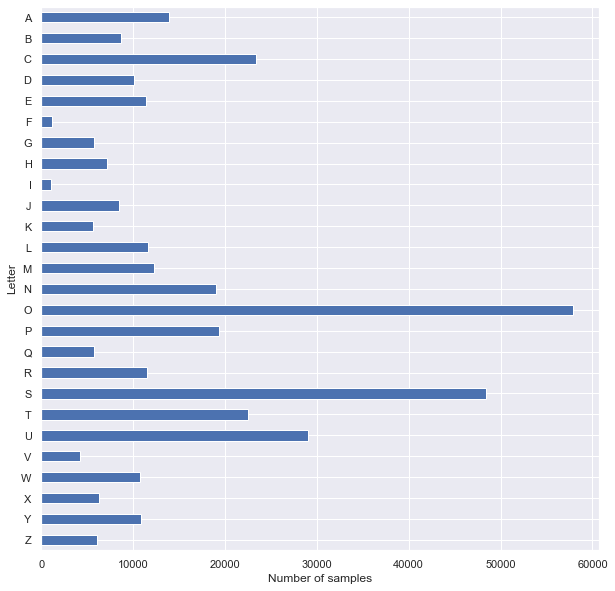

In [116]:
alphabet = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}
datos = deepcopy(letras.data)
datos['label'] = datos['label'].map(alphabet)

label_size = datos.groupby('label').size()
ax = label_size.plot(kind="barh", figsize=(10,10))
plt.xlabel("Number of samples")
plt.ylabel("Letter")
ax.invert_yaxis()
plt.show()

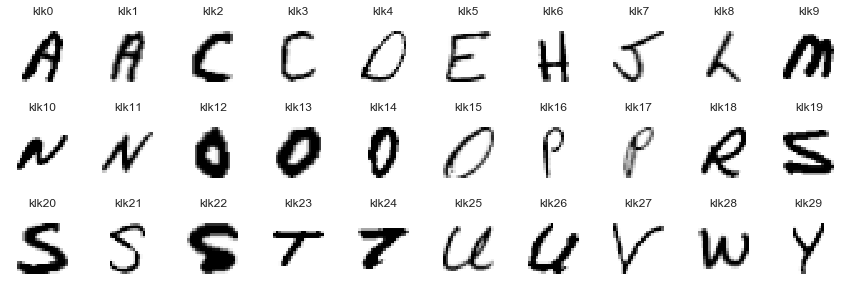

In [130]:
plt.figure(figsize = (15,5))
row, col = 10, 3
numero = int(letras.X.shape[0]/(row*col))
for i in range(row*col):
    plt.subplot(col, row, i+1)
    plt.imshow(letras.X.iloc[i*numero].values.reshape(28,28),interpolation='nearest', cmap='Greys')
    plt.title("klk"+str(i))
    plt.axis('off')
plt.show()

In [118]:
#letras.train()

In [119]:
#letras.saveNN()

In [120]:
letras.loadNN()

Loaded model from json file


In [121]:
letras.test()

(93113, 28, 28, 1)
CNN Score: 0.9970465898513794


In [125]:
path = glob.glob("imgslletres/*.jpg")
imgs = []
for i in path:
    n = cv2.imread(i, 0)
    imgs.append(n)
    
npa = np.asarray(imgs, dtype=np.float32)

In [128]:
print(npa.shape)
npa2 = npa.reshape(npa.shape[0], npa.shape[1], npa.shape[2], 1)
print(npa2.shape)
klk = letras.predict(npa2)

(13, 28, 28)
(13, 28, 28, 1)


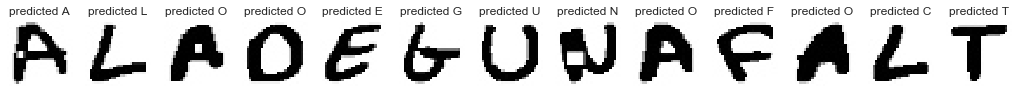

In [137]:
plt.figure(figsize = (18,5))
row, col = 13, 1
for i in range(row*col):
    plt.subplot(col, row, i+1)
    plt.imshow(npa[i], interpolation='nearest', cmap='Greys')
    pred = alphabet[np.argmax(klk[i])]
    plt.title("predicted "+str(pred))
    plt.axis('off')
plt.show()

In [ ]:
"""# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()"""